# Report 2
## Solving weighted graph assignment problem with simulated annealing

#### Michał Sitko, Krzysztof Jankowski

In [108]:
from graph import *
from simulated_annealing import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import itertools as it
import numpy as np

This report will cover tests and analysis of a tool for solving graph assignment problem. For detailed explanation about implementation insights please see the 'Report 1'.

### 0. Setup

We will be using several randomly generated full-bipartite graphs:

In [ ]:
# extra small
G_xsmall = Graph.random_bipartite(3, 11, -3.52, 7.23)

# medium
G_medium_r = Graph.random_bipartite(30, 85, 0, 10)
G_medium_l = Graph.random_bipartite(106, 28, 0, 10)

Let's define 2 general plotting functions. They will be used to show algorithm performance indicators for various algorithm parameters.

In [250]:
def report_2d(results, x, x_label, x_scale='linear'):
    f, ax = plt.subplots(2, 2)

    ax[0, 0].plot(x, [r.total_time for r in results])
    ax[0, 0].set_title('Total time')
    ax[0, 0].set_xscale(x_scale)
    ax[0, 0].set_ylabel('Time (s)')

    ax[0, 1].plot(x, [r.solution.get_estimate() for r in results])
    ax[0, 1].set_title('Optimal solution value')
    ax[0, 1].set_xscale(x_scale)
    ax[0, 1].set_ylabel('Value')

    ax[1, 0].plot(x, [r.max_i_s2 for r in results])
    ax[1, 0].set_title('STEP 2')
    ax[1, 0].set_xscale(x_scale)
    ax[1, 0].set_ylabel('Number of iterations')

    ax[1, 1].plot(x, [r.max_i_s3 for r in results])
    ax[1, 1].set_title('STEP 3')
    ax[1, 1].set_xscale(x_scale)
    ax[1, 1].set_ylabel('Number of iterations')

    f.set_size_inches(15, 7)
    plt.show()

In [251]:
def report_3d(results, x, x_label, y, y_label, x_scale='linear', y_scale='linear'):
    def reshape(prop_selector):
        return list(map(prop_selector, results))
    
    f = plt.figure()
    
    ax00 = f.add_subplot(221, projection='3d')
    ax00.scatter(x, y, reshape(lambda x: x.total_time))
    ax00.set_title('Total time')
    ax00.set_xlabel(x_label)
    ax00.set_xscale(x_scale)
    ax00.set_ylabel(y_label)
    ax00.set_yscale(y_scale)
    ax00.set_zlabel('Time (s)')

    ax01 = f.add_subplot(222, projection='3d')
    ax01.scatter(x, y, reshape(lambda x: x.solution.get_estimate()))
    ax01.set_title('Optimal solution value')
    ax01.set_xlabel(x_label)
    ax01.set_xscale(x_scale)
    ax01.set_ylabel(y_label)
    ax01.set_yscale(y_scale)
    ax01.set_zlabel('Value')

    ax10 = f.add_subplot(223, projection='3d')
    ax10.scatter(x, y, reshape(lambda x: x.max_i_s2))
    ax10.set_title('STEP 2')
    ax10.set_xlabel(x_label)
    ax10.set_xscale(x_scale)
    ax10.set_ylabel(y_label)
    ax10.set_yscale(y_scale)
    ax10.set_zlabel('Number of iterations')

    ax11 = f.add_subplot(224, projection='3d')
    ax11.scatter(x, y, reshape(lambda x: x.max_i_s3))
    ax11.set_title('STEP 3')
    ax11.set_xlabel(x_label)
    ax11.set_xscale(x_scale)
    ax11.set_ylabel(y_label)
    ax11.set_yscale(y_scale)
    ax11.set_zlabel('Number of iterations')

    f.set_size_inches(25, 15)
    plt.show()


### 1. Correctness

#### Linear

Let's start the algorithm analysis by evaluating results for a few simple examples - extra small (*14 vertices*) graph, linear schedule and low temperature interval - *0.0-5.0 deg*. Such setup should intuitively give clear and pretty well results. Since linear schedule's `a` parameter is set to a very small value, we can expect that algotithm will go through several thousands of iterations. Therefore we set observation interval to *100*.

In [80]:
p = SimulatedAnnealingParameters(
    t_max=5,
    t_min=0,
    k_t=3,
    cooling_scheme=CoolingSchemeLinear(0.001),
    i_s2_observation_interval=100,
    i_s3_observation_interval=100
)

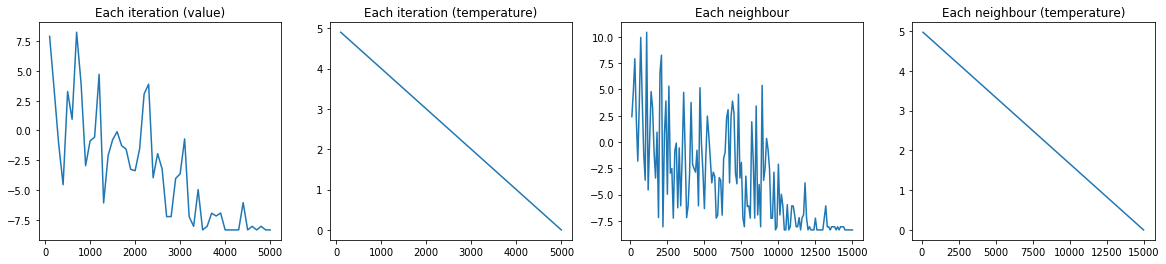

In [81]:
SimulatedAnnealing.execute(G_xsmall, p).draw_observations_plot()

In the plots, presented above, we see partial solution values (Y) over the number of iterations (X). The left one shows results in iteration frames. The right one after evaluation of each neighbour. Since the number of neighbours searched is set to 3, then the right plot should present 3 times more datapoints than the left one.

It is clearly noticeable that the algorithm is converging over time. Alongside the variance of the total value is decreasing. Since linear schedule was used the temperature is decreasing linearly.

Let's compare the schedule with two other implemented (exponential and logarithmic). Arbitrary cooling scheme parameters values will be used.

#### Exponential

In order to perform calculations for exponential schedule the minimal temperature value should be increased. Any value above 0 is satisfactionary (however the algorithm can converge when *t_min* is set to 0. This can happen due to numerical precision limitations. Very low temperature value outputted by the exponential schedule, can be rounded to 0).  

In [82]:
p = SimulatedAnnealingParameters(
    t_max=6,
    t_min=1,
    k_t=3,
    cooling_scheme=CoolingSchemeExponential(0.99),
    i_s2_observation_interval=1,
    i_s3_observation_interval=1
)

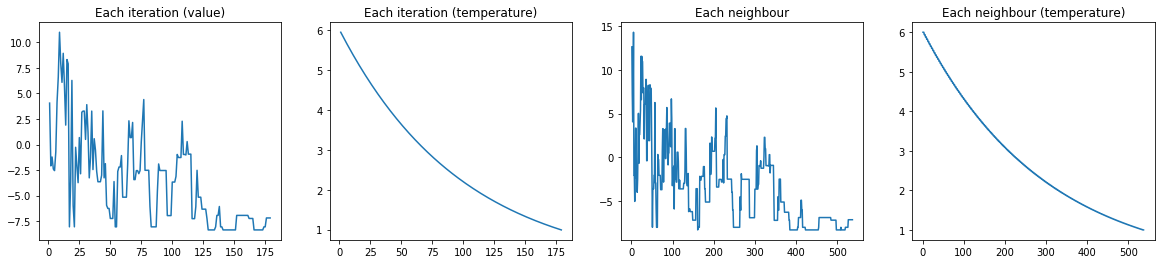

In [87]:
SimulatedAnnealing.execute(G_xsmall, p).draw_observations_plot()

The algorithm required less iterations in order to converge than in previous example. This however resulted in poorer search of the solutions' space (less solutions distant from the optimal one were searched).

#### Logarithmic

In [88]:
p = SimulatedAnnealingParameters(
    t_max=6,
    t_min=1,
    k_t=3,
    cooling_scheme=CoolingSchemeLogarithmic(5, 5),
    i_s2_observation_interval=1,
    i_s3_observation_interval=1
)

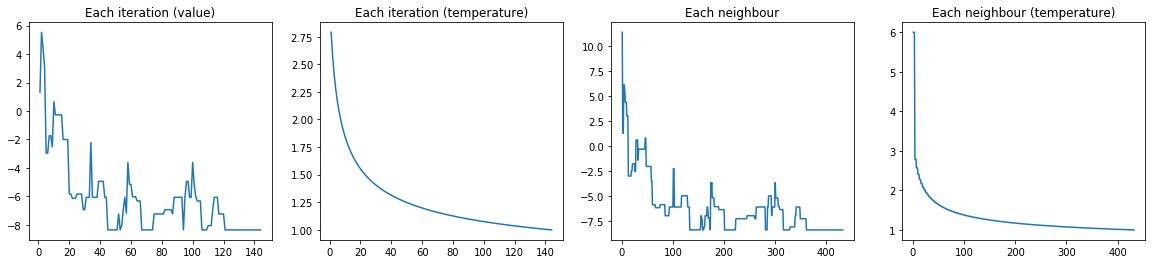

In [91]:
SimulatedAnnealing.execute(G_xsmall, p).draw_observations_plot()

The logarithmic scheme, with carefully adjusted C and D parameters requered even less iterations than exponential in order to converge.

Taking all three experiments together we notice that the optimal solution is somewhere around -8. None of the evaluations outputted better results. Moreover it shall be noted that mainaining lower values of temperature seems to reveal better solutions quicker for the considered problem (*weighted graph assignment*).

### 2. Testing cooling scheme parameters

In the following section we will try to examine how different values of cooling scheme parameters change algorithm overall performance. Medium size graphs will be used.

#### Linear

In [126]:
p = SimulatedAnnealingParameters(
    t_max=5,
    t_min=0,
    k_t=1,
    cooling_scheme=CoolingSchemeLinear(1)
)

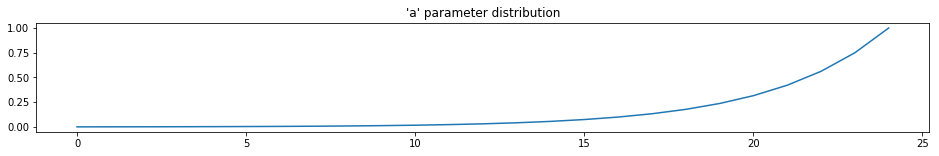

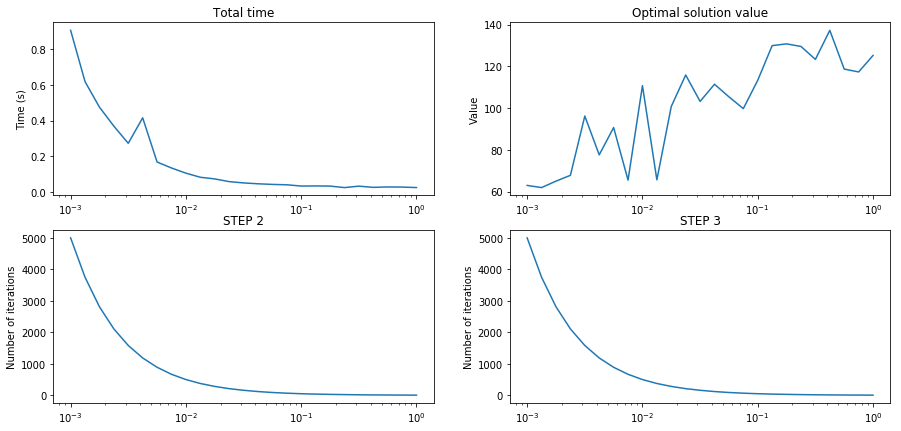

In [197]:
results = []
a_s = np.geomspace(0.001, 1, num=25)

plt.figure(figsize=(16,2))
plt.title('\'a\' parameter distribution')
plt.plot(a_s)
plt.show()

for a in a_s:
    p.cooling_scheme = CoolingSchemeLinear(a)
    results.append(SimulatedAnnealing.execute(G_medium_r, p))
    
report_2d(results, a_s, '\'a\' factor', x_scale='log')

On the 'x' axis values of `a` parameter were shown (in log scale). Naturally with decrease of `a` parameter the number of iterations of the algorithm increases and thus its overall performance.

#### Exponential

In [129]:
p = SimulatedAnnealingParameters(
    t_max=6,
    t_min=1,
    k_t=1,
    cooling_scheme=CoolingSchemeExponential(0.99)
)

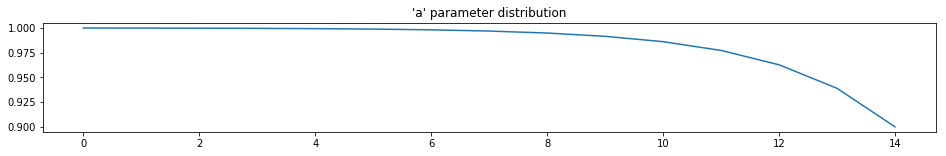

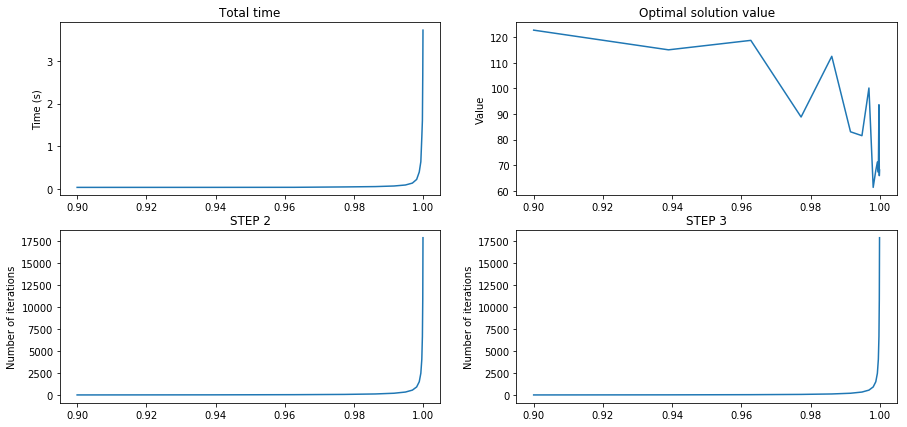

In [203]:
results = []
a_s = 1 - np.geomspace(0.0001, 0.1, num=15)

plt.figure(figsize=(16,2))
plt.title('\'a\' parameter distribution')
plt.plot(a_s)
plt.show()

for a in a_s:
    p.cooling_scheme = CoolingSchemeExponential(a)
    results.append(SimulatedAnnealing.execute(G_medium_r, p))
    
report_2d(results, a_s, '\'a\' factor', x_scale='linear')

`a` parameter for exponential schedule tend to show oposite performance to the previous example.

#### Logarithmic

Logarithmic cooling scheme will never reach 0 minimal temperature, therefore we change it to 1.

In [204]:
p = SimulatedAnnealingParameters(
    t_max=6,
    t_min=1,
    k_t=1,
    cooling_scheme=CoolingSchemeLogarithmic(1, 1)
)

In [205]:
c_s = np.linspace(0.1, 5, num=10)
d_s = np.linspace(1, 100, num=25)
cd_s = list(it.product(c_s, d_s))
c_s = [x[0] for x in cd_s]
d_s = [x[1] for x in cd_s]

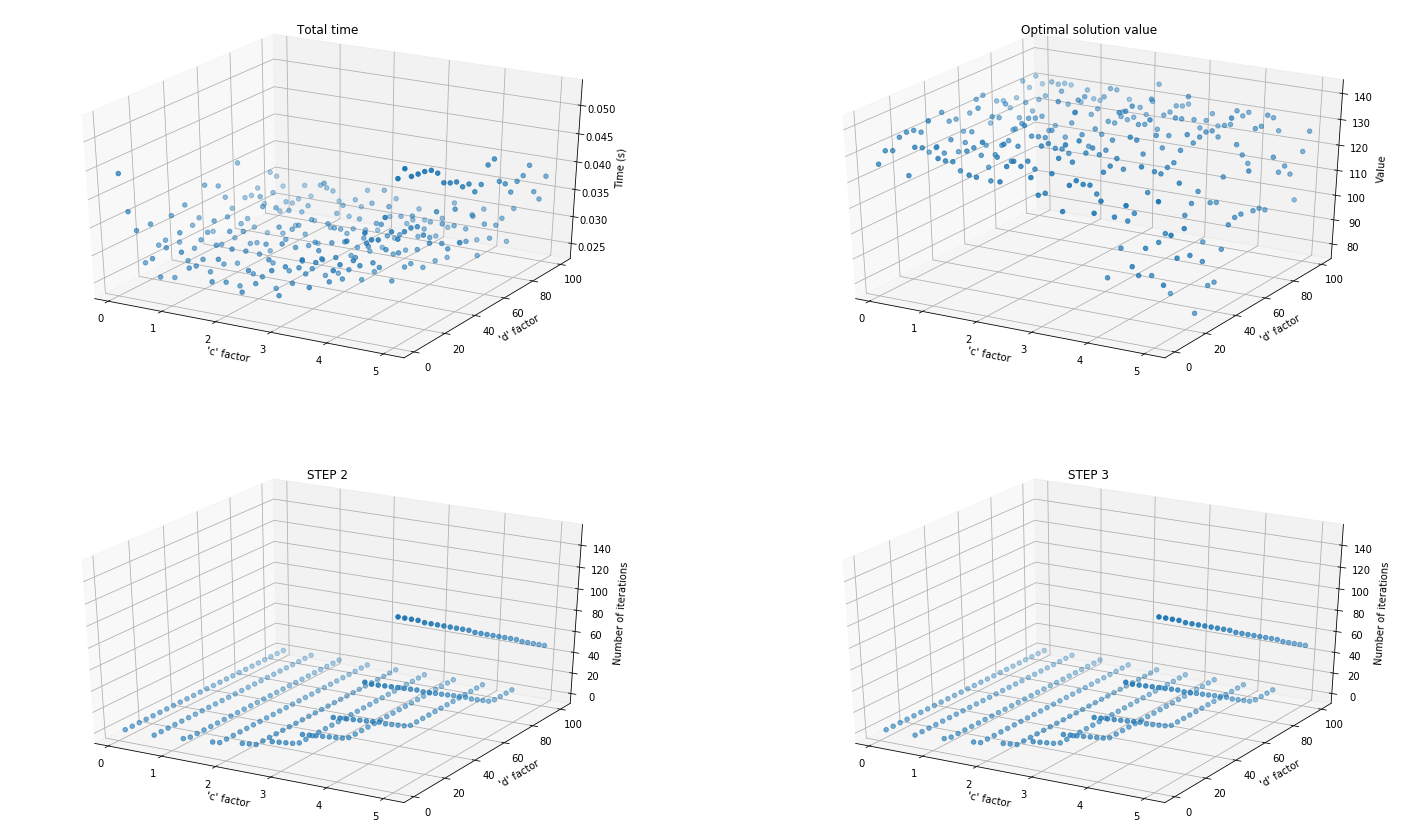

In [206]:
results = []
for cd in cd_s:
    p.cooling_scheme = CoolingSchemeLogarithmic(c=cd[0], d=cd[1])
    results.append(SimulatedAnnealing.execute(G_medium_r, p))
        
report_3d(results, c_s, '\'c\' factor', d_s, '\'d\' factor')

We see that with increase of `C` factor and decrease of `D` algorithm tend to have more iterations and for the given problem find better solutions.

### 3. Temperatures

It is crucial to adjust min and max temperature values for the given problem. If the interval will be to high (too hot). The algorithm will be unable to find optimal values (too much spending on searching the entire space). On the other hand too low temperatures will prevent the optimizer to test different values in the space and will possibly result in finding some local optimum. To prove that we will perform two experiments using the same parameter settings, except temperature intervals.

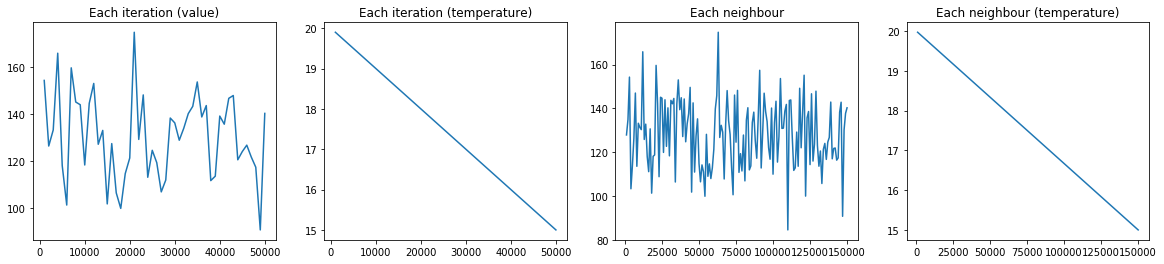

Best solution found: 137.65999999999997.


In [231]:
p = SimulatedAnnealingParameters(
    t_max=20,
    t_min=15,
    k_t=3,
    cooling_scheme=CoolingSchemeLinear(0.0001),
    i_s2_observation_interval=1000,
    i_s3_observation_interval=1000
    
)
result = SimulatedAnnealing.execute(G_medium_l, p)
result.draw_observations_plot()
print('Best solution found: %s.' % result.solution.get_estimate())

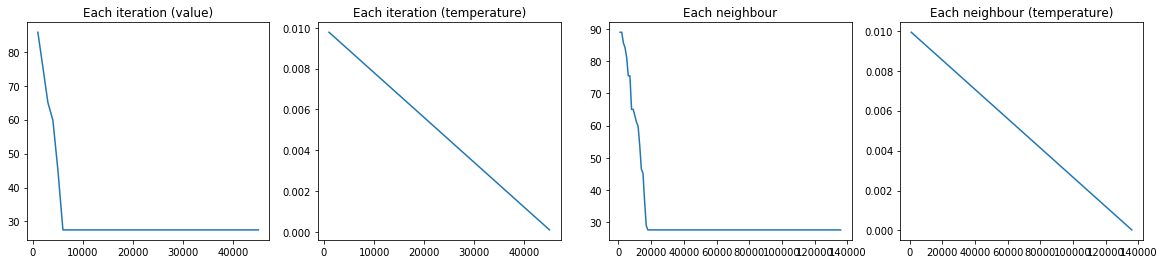

Best solution found: 32.739999999999995.


In [230]:
p = SimulatedAnnealingParameters(
    t_max=0.01,
    t_min=0,
    k_t=3,
    cooling_scheme=CoolingSchemeLinear(0.00000022),
    i_s2_observation_interval=1000,
    i_s3_observation_interval=1000
    
)
result = SimulatedAnnealing.execute(G_medium_l, p)
result.draw_observations_plot()
print('Best solution found: %s.' % result.solution.get_estimate())

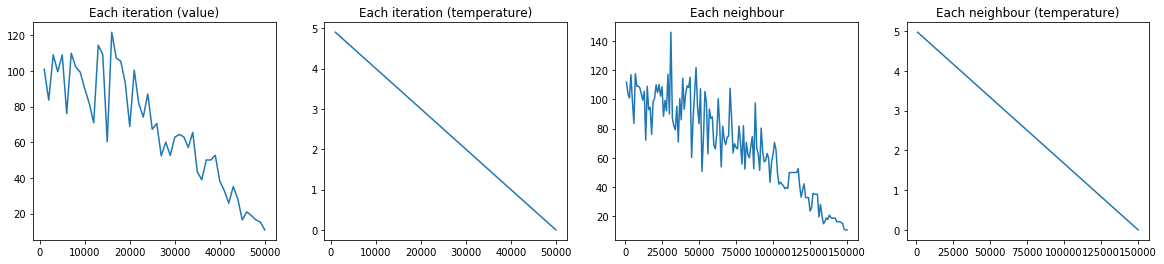

Best solution found: 18.35.


In [232]:
p = SimulatedAnnealingParameters(
    t_max=5,
    t_min=0,
    k_t=3,
    cooling_scheme=CoolingSchemeLinear(0.0001),
    i_s2_observation_interval=1000,
    i_s3_observation_interval=1000
    
)
result = SimulatedAnnealing.execute(G_medium_l, p)
result.draw_observations_plot()
print('Best solution found: %s.' % result.solution.get_estimate())

As it is clearly seen in the plots, taking too high (15-20) temperature interval prevents the algorithm from converging. Setting too low temperatures (0-0.01) also do not seem to be the best solution, since local minimum can prevent algorithm with finding better solutions early. For medium (L) graph 0-5 seems to be reasonable choice.

### 4. Natural datasets

In this section we will try to test an algorithm against external, naturally generated dataset. One from many available in the internet was chosen. The selection criteria were problem fit (dataset must be a weighted, bipartite graph), size (we looked for something pretty big, in order to test the performance) and 'coolness' of the doman. We chose 'Escorts' dataset, provided by the University of Koblenz (Germany).

This is the bipartite network of sex buyers and their escorts. Nodes are buyers and escorts. An edge denotes sexual intercourse between a male sex-buyer and a female escort. Edges are weighted with the rating of the escort given by the buyer. Three ratings are possible: bad (−1), neutral (0), good (+1).

#### Escorts  - 'natural' dataset scenario

In [234]:
import urllib.request
import tarfile
import os

# download dataset tar archive
os.makedirs('./data', exist_ok=True)
urllib.request.urlretrieve("http://konect.uni-koblenz.de/downloads/tsv/escorts.tar.bz2", "./data/escorts.tar.bz2")

# extract archive
tar = tarfile.open('./data/escorts.tar.bz2', 'r:bz2')
tar.extractall('./data')
tar.close()

# remove archive
os.remove('./data/escorts.tar.bz2')

The dataset needs to be preprocessed before analysis. Since the first column contains unique id-s and the second one also (but both are in different identity spaces) we shall make them unique. We do so by prefixing the left side with b_ (like buyer) and the right side with e_ (like escort). We also inverse the edge value (change negative opinions (-1) with positive (1) - so that now minimization applied by the algorithm will result in finding the most satisfactionary assignment - for buyers). The last column (timestamp) can be discarded.

In [235]:
import csv

i = 0
i_limit = 100000000 # no_limit

with open('./data/escorts/out.escorts.prep', 'w+') as out_file:
    with open('./data/escorts/out.escorts', 'r') as in_file:
        reader = csv.reader(in_file, delimiter=' ')
        for row in reader:
            if row[0] == '%':
                continue
            
            if i >= i_limit:
                break
            
            out_file.write('b_%s e_%s %s\n' % (row[0], row[1], -int(row[2])))
            i += 1

Now let's load a preprocessed graph into the memory and invoke the implemented algorithm.

In [236]:
import networkx as nx
from simulated_annealing import *

nx_escorts = nx.read_edgelist('./data/escorts/out.escorts.prep', comments='%', delimiter=' ', data=(('weight', int),))

In [237]:
from networkx.algorithms import bipartite

print('It is indeed a bipartite graph.' if bipartite.is_bipartite(nx_escorts) else 'It is not a bipartite graph :(')
print('There are %s buyers and escorts in total.' % nx_escorts.number_of_nodes())

buyer_nodes = {n for n, d in nx_escorts.nodes(data=True) if 'b_' in n}
escort_nodes = set(nx_escorts) - buyer_nodes

print('%s of them are buyers and %s are escorts.' % (len(buyer_nodes), len(escort_nodes)))
print('%s no. of \'transactions\' were registered.' % nx_escorts.number_of_edges())

It is indeed a bipartite graph.
There are 16730 buyers and escorts in total.
10106 of them are buyers and 6624 are escorts.
39044 no. of 'transactions' were registered.


In [247]:
parameters = SimulatedAnnealingParameters(
    t_max=5,
    t_min=0,
    k_t=1,
    cooling_scheme=CoolingSchemeLinear(0.0001),
    i_s2_observation_interval=1000,
    i_s3_observation_interval=1000
)

result = SimulatedAnnealing.execute(nx_escorts, parameters)

In [248]:
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 6.094804241953636e+22 found in 50000 iterations (695.0971021652222 time).


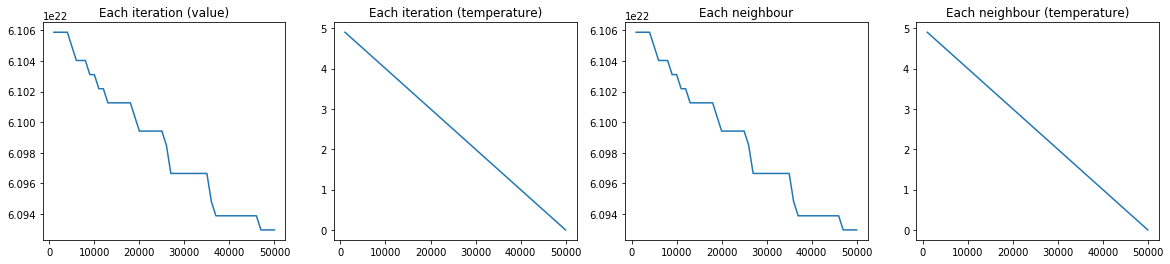

In [249]:
result.solution.get_estimate()
result.draw_observations_plot()

During whole run the algorithm kept constant memory demand (~288M - checked monitoring `top` results). However it consumed all available CPU.

### 5. Conclusions

* Temperature intervals should be carefully adjusted to the problem solved (too high temperatures - non converging runs, too low - runs which easily stuck in local minima).
* By using different cooling schemes we can change search strategy of our algorithm. Simple Linear schedule allocates search types equaly over iterations with high and low temperatures. Using different schedules allow the user to increase the number of low temperatures / high temperatures in the single run.
* Implemented algorithm can optimize pretty big problems - graphs having many thousands of vertices. According to the 'natural DS' experiment, memory consumption is not very high. The solution is rather CPU (not memory) bound.
* The bigger the problem is the more 'low temperature' iterations it needs in order to find an optimum.